In [69]:
import numpy as np
from random import shuffle
import time
import sys
import random


class PokerB:

    def __init__(self):
        self.nodeMap = {}
        self.expected_game_value = 0
        self.n_cards = 10
        self.nash_equilibrium = dict()
        self.current_player = 0
        self.deck = list(['2H','3H','4H','5H','6H','7H','8H','9H','TH','JH','QH','KH','AH',
                             '2D','3D','4D','5D','6D','7D','8D','9D','TD','JD','QD','KD','AD',
                             '2S','3S','4S','5S','6S','7S','8S','9S','TS','JS','QS','KS','AS',
                             '2C','3C','4C','5C','6C','7C','8C','9C','TC','JC','QC','KC','AC'])
        self.n_actions = 2
    
            
        
    def train(self, player1_cards, n_iterations,i):
        expected_game_value = 0
        #player1_cards= random.sample(self.deck, 5)
        for _ in range(n_iterations):
            shuffle(self.deck)
            expected_game_value += self.cfr('', player1_cards, 1, 1,i)
            for _, v in self.nodeMap.items():
                v.update_strategy()

        expected_game_value /= n_iterations
        display_results(expected_game_value, self.nodeMap,i)
    

    def cfr(self, history, player1_cards, pr_1, pr_2,i):
        n = len(history)
        is_player_1 = n % 2 == 0
        player_card = self.deck[0] if is_player_1 else self.deck[1]  
        for element in player1_cards:
            if element in self.deck:
                self.deck.remove(element)
        if self.is_terminal(history):
            card_opponent = random.sample(self.deck, 5)
            reward = self.get_reward(history, player1_cards, card_opponent,i)
            return reward

        node = self.get_node(player1_cards, history)
        strategy = node.strategy

        # Counterfactual utility per action.
        action_utils = np.zeros(self.n_actions)
        
        for act in range(self.n_actions):
            next_history = history + node.action_dict[act]
            if is_player_1:
                action_utils[act] = -1 * self.cfr(next_history, player1_cards, pr_1 * strategy[act], pr_2,i)
            else:
                action_utils[act] = -1 * self.cfr(next_history, player1_cards, pr_1, pr_2 * strategy[act],i)

        # Utility of information set.
        util = sum(action_utils * strategy)
        regrets = action_utils - util
        if is_player_1:
            node.reach_pr += pr_1
            node.regret_sum += pr_2 * regrets
        else:
            node.reach_pr += pr_2
            node.regret_sum += pr_1 * regrets

        return util

    @staticmethod
    def is_terminal(history):
        if history[-2:] == 'pp' or history[-2:] == "bb" or history[-2:] == 'bp':
            return True

    @staticmethod
    def get_reward(history, player1_cards, player2_cards,i):
        terminal_pass = history[-1] == 'p'
        double_bet = history[-2:] == "bb"
        if terminal_pass:
            if history[-2:] == 'pp':
                if rank_hand(player1_cards) > rank_hand(player2_cards):
                    return 1
                elif rank_hand(player1_cards) < rank_hand(player2_cards):
                    return (-1)
                elif rank_hand(player1_cards) == rank_hand(player2_cards):
                    rank = rank_hand(player1_cards)
                    winner = tie(player1_cards, player2_cards, rank)
                    if winner == 'Player1':
                        return 1
                    if winner == 'Player2':
                        return (-1)
            else:
                return 1
            
        elif double_bet:
            if rank_hand(player1_cards) > rank_hand(player2_cards):
                return (1+i)
            elif rank_hand(player1_cards) < rank_hand(player2_cards):
                return (-1-i)
            elif rank_hand(player1_cards) == rank_hand(player2_cards):
                    rank = rank_hand(player1_cards)
                    winner = tie(player1_cards, player2_cards, rank)
                    if winner == 'Player1':
                        return 1+i
                    if winner == 'Player2':
                        return (-1-i)


    def get_node(self, card, history):
        key = str(card) + " " + history
        if key not in self.nodeMap:
            action_dict = {0: 'p', 1: 'b'}
            info_set = Node(key, action_dict)
            self.nodeMap[key] = info_set
            return info_set
        return self.nodeMap[key]


class Node:
    def __init__(self, key, action_dict, n_actions=2):
        self.key = key
        self.n_actions = n_actions
        self.regret_sum = np.zeros(self.n_actions)
        self.strategy_sum = np.zeros(self.n_actions)
        self.action_dict = action_dict
        self.strategy = np.repeat(1/self.n_actions, self.n_actions)
        self.reach_pr = 0
        self.reach_pr_sum = 0

    def update_strategy(self):
        self.strategy_sum += self.reach_pr * self.strategy
        self.reach_pr_sum += self.reach_pr
        self.strategy = self.get_strategy()
        self.reach_pr = 0

    def get_strategy(self):
        regrets = self.regret_sum
        regrets[regrets < 0] = 0
        normalizing_sum = sum(regrets)
        if normalizing_sum > 0:
            return regrets / normalizing_sum
        else:
            return np.repeat(1/self.n_actions, self.n_actions)

    def get_average_strategy(self):
        strategy = self.strategy_sum / self.reach_pr_sum
        # Re-normalize
        total = sum(strategy)
        strategy /= total
        return strategy

    def __str__(self):
        strategies = ['{:03.2f}'.format(x)
                      for x in self.get_average_strategy()]
        return '{} {}'.format(self.key.ljust(6), strategies)


def display_results(ev, i_map,n):
    print('betting value: {}'.format(n))
    print('player 1 expected value: {}'.format(ev))
    print('player 2 expected value: {}'.format(-1 * ev))

    print()
    print('player 1 strategies:')
    sorted_items = sorted(i_map.items(), key=lambda x: x[0])
    for _, v in filter(lambda x: len(x[0]) % 2 == 1,i_map.items()):
        print(v)
    print()
    print('player 2 strategies:')
    for _, v in filter(lambda x: len(x[0]) % 2 == 0, i_map.items()):
        print(v)

if __name__ == "__main__":
    cards_sequence = {"2H":2, "3H":3, "4H":4, "5H":5, "6H":6, "7H":7, "8H":8, "9H":9, "TH":10,"JH":11, "QH":12, "KH":13, "AH":14,
                     "2D":2, "3D":3, "4D":4, "5D":5, "6D":6, "7D":7, "8D":8, "9D":9, "TD":10,"JD":11, "QD":12, "KD":13, "AD":14,
                     "2S":2, "3S":3, "4S":4, "5S":5, "6S":6, "7S":7, "8S":8, "9S":9, "TS":10,"JS":11, "QS":12, "KS":13, "AS":14,
                      "2C":2, "3C":3, "4C":4, "5C":5, "6C":6, "7C":7, "8C":8, "9C":9, "TC":10,"JC":11, "QC":12, "KC":13, "AC":14,}
    cards_suits ={"2H":'H', "3H":'H', "4H":'H', '5H':'H', "6H":'H', "7H":'H', "8H":'H', "9H":'H', "TH":'H',"JH":'H', "QH":'H', "KH":'H', "AH":'H',
                     "2D":'D', "3D":'D', "4D":'D', "5D":'D', "6D":'D', "7D":'D', "8D":'D', "9D":'D', "TD":'D',"JD":'D', "QD":'D', "KD":'D', "AD":'D',
                     "2S":'S', "3S":'S', "4S":'S', "5S":'S', "6S":'S', "7S":'S', "8S":'S', "9S":'S', "TS":'S',"JS":'S', "QS":'S', "KS":'S', "AS":'S',
                      "2C":'C', "3C":'C', "4C":'C', "5C":'C', "6C":'C', "7C":'C', "8C":'C', "9C":'C', "TC":'C',"JC":'C', "QC":'C', "KC":'C', "AC":'C',}
    time1 = time.time()
    trainer = PokerB()
    player_1 = ['2D', '5H', 'KD', '9S', '3C']

    trainer.train(player_1,5000,2)
    print(abs(time1 - time.time()))
    print(sys.getsizeof(trainer))
    

betting value: 2
player 1 expected value: -0.08600156615449385
player 2 expected value: 0.08600156615449385

player 1 strategies:
['2D', '5H', 'KD', '9S', '3C']  ['0.85', '0.15']
['2D', '5H', 'KD', '9S', '3C'] pb ['0.01', '0.99']

player 2 strategies:
['2D', '5H', 'KD', '9S', '3C'] p ['0.90', '0.10']
['2D', '5H', 'KD', '9S', '3C'] b ['0.01', '0.99']
2.297412157058716
48


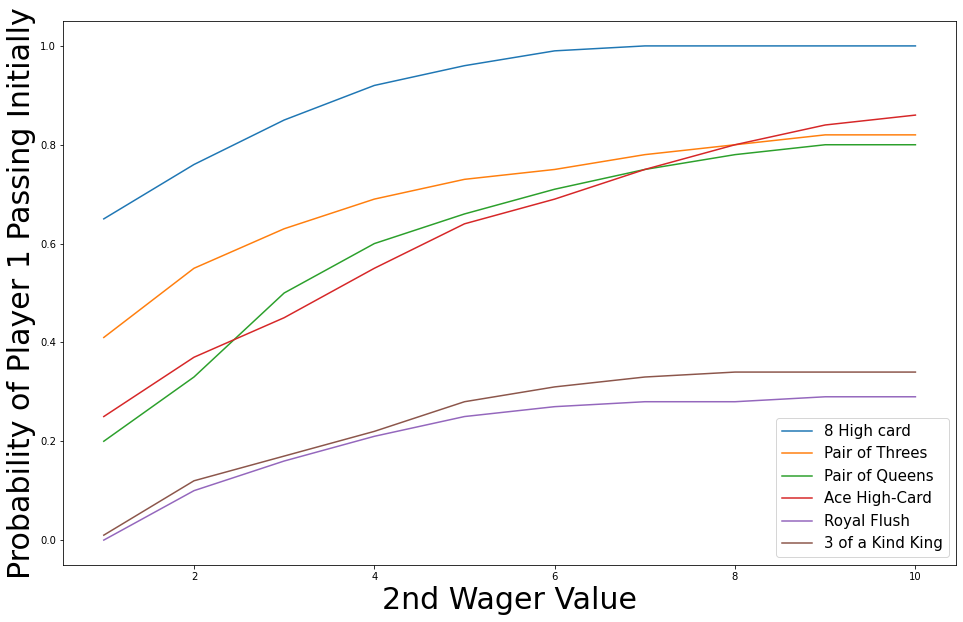

In [56]:
import matplotlib.pyplot as plt
a1 = [0.41,0.55,0.63,0.69,0.73,0.75,0.78,0.80,0.82,0.82]
a2 = [0.2,0.33,0.5,0.6,0.66,0.71,0.75,0.78,0.80,0.80]
a3= [ 0.25,0.37,0.45,0.55,0.64,0.69,0.75,0.8,0.84,0.86]
a4= [0.65, 0.76, 0.85,0.92,0.96,0.99,1,1,1,1]
a5= [ 0.01,0.12,0.17,0.22,0.28,0.31,0.33,0.34,0.34,0.34]
a6= [ 0.0, 0.1,0.16,0.21,0.25,0.27,0.28,0.28,0.29,0.29]
t = [1,2,3,4,5,6,7,8,9,10]
plt.figure(figsize=(16,10))
plt.plot(t,a4, label="8 High card")
plt.plot(t,a1,label="Pair of Threes")
plt.plot(t,a2,label="Pair of Queens")
plt.plot(t,a3,label="Ace High-Card")
plt.plot(t,a6,label="Royal Flush")
plt.plot(t,a5, label="3 of a Kind King")
plt.legend(fontsize=15)
plt.xlabel("2nd Wager Value", fontsize=30)

plt.ylabel("Probability of Player 1 Passing Initially",fontsize=30)
plt.savefig('probability.png')

In [1]:


from collections import defaultdict 
import sys

def one_pair(hand):
    
    """ This funtion will check whether a pair exist in the hand or not.
    It will give 2 outputs, the first one is a boolean value and the second one is the pair value (if it exists)"""
    
    values = hand
    value_counter = defaultdict(lambda:0)
    for i in values:
        value_counter[i] += 1
    key_list = list(value_counter.keys()) 
    val_list = list(value_counter.values())
    if 2 in value_counter.values():
        return True, key_list[val_list.index(2)]
    else:
        return False, None
    
def two_pairs(hand): 
    
    """ This funtion will check whether there are two set of pairs in the hand or not.
    It will give 3 outputs, the first one is a boolean value, the second one is a list of 2 values whose pair exist in the hand and finally the 3rd output is a number whose pair doesn't exist."""
    
    pairs = []
    non_pair_value = 0
    values = hand
    value_counter = defaultdict(lambda:0)
    for i in values:
        value_counter[i]+=1
    key_list = list(value_counter.keys()) 
    val_list = list(value_counter.values())
    # For loop below finds the card's which form a pair in this hand
    for i in range(len(val_list)):
        if val_list[i] == 2:
            pairs.append(key_list[i])
        else:
            non_pair_value = key_list[i]
    if sorted(value_counter.values())==[1,2,2]:
        return True, pairs, non_pair_value
    else:
        return False, None, None
    
def three_of_kind(hand):
    
    """ This funtion will check whether a Three of a kind is present in the hand or not.
    It will give 2 outputs, the first one is a boolean value and the second one is the card value whose Three of a Kind exists."""
    
    values = [v[0] for v in hand]
    value_counter = defaultdict(lambda:0)
    for i in hand:
        value_counter[i]+=1
    key_list = list(value_counter.keys()) 
    val_list = list(value_counter.values())
    if 3 in value_counter.values():
        return True, key_list[val_list.index(3)]
    else:
        return False, None

def straight(hand):

    """ This funtion will check whether a Straight is present in the hand or not.
    It will give 1 output which is a boolean value."""

    values = [v[0] for v in hand]
    values_only_numbers = []
    for i in hand:
        values_only_numbers.append(cards_sequence[i])
    if sorted(values_only_numbers) == [k for k in range(min(values_only_numbers), max(values_only_numbers)+1)]:
        return True
    else:
        return False

def flush(hand):

    """ This funtion will check whether a Flush is present in the hand or not.
    It will give 1 output which is a boolean value."""

    suits = []
    for i in hand:
        suits.append(cards_suits[i])
    if len(set(suits)) == 1:
        return True
    else:
        return (False)

def full_house(hand):

    """ This funtion will check whether a Full House is present in the hand or not.
    It will give 1 output which is a boolean value."""

    if one_pair(hand)[0] and three_of_kind(hand)[0]:
        return True
    else:
        return False

def four_of_kind(hand):

    """ This funtion will check whether a Four of a Kind is present in the hand or not.
    It will give 2 outputs. The first one is a boolean value and the 2nd one is a card value whose Four of a Kind exists."""

    values = hand
    value_counter = defaultdict(lambda:0)
    for i in values:
        value_counter[i]+=1
    key_list = list(value_counter.keys()) 
    val_list = list(value_counter.values())
    if 4 in value_counter.values():
        return True, key_list[val_list.index(4)]
    else:
        return False, None

def straight_flush(hand):

    """ This funtion will check whether a Straight Flush is present in the hand or not.
    It will give 1 output which is a boolean value."""

    if straight(hand) and flush(hand):
        return True
    else:
        return False

def royal_flush(hand):

    """ This funtion will check whether a Royal Flush is present in the hand or not.
    It will give 1 output which is a boolean value."""

    values = [v[0] for v in hand]
    values_only_numbers = []
    for i in hand:
        values_only_numbers.append(cards_sequence[i])
    if straight(hand) and flush(hand):
        if sorted(values_only_numbers)[0] == 10:
            return True
        else:
            return False

def rank_hand(hand):

    """ This function will run 9 different functions where each one is checking for a possible combination of five playing cards. 
        Once the combination is found it will then output a suitable rank. The default combination is High Card whose rank is 1."""


    if royal_flush(hand):
        return 10
    if straight_flush(hand):
        return 9
    if four_of_kind(hand)[0]:
        return 8
    if full_house(hand):
        return 7
    if flush(hand):
        return 6
    if straight(hand):
        return 5
    if three_of_kind(hand)[0]:
        return 4
    if two_pairs(hand)[0]:
        return 3
    if one_pair(hand)[0]:
        return 2
    return 1 # High Card

def list_comparison(a, b): # a and b have to be list with only numbers for example if it is Ace than its corresponding number would be 14

    """ This function will compare two lists of numbers (with no duplicate values). This function helps in determining a winner (tie breaker) based on the highest value of card. """


    listA = sorted(a, reverse=True)
    listB = sorted(b, reverse=True)
    for i in range(0,len(a)):
        if listA[i] != listB[i]:
            if listA[i] > listB[i]:
                return 'Player1'
            elif listA[i] < listB[i]:
                return 'Player2'
            break # Exit the loop
        else:
            continue # Skip

def tie(hand1, hand2, rank):

    """ When the ranks are same than this funtion is used as a tie breaker.

        How  does it work ?

        It works by comparing the highest cards in each hand; if the highest cards tie then the next highest cards are compared and so on. """
    
    values1 = hand1
    values2 = hand2
    # Converting card value to their corresponding numeric value using 'card_sequence' dictionary which is defined under the main function.
    values1_only_numbers = []
    for i in values1:
        values1_only_numbers.append(cards_sequence[i])
    values2_only_numbers = []
    for i in values2:
        values2_only_numbers.append(cards_sequence[i])   
    
    if rank == 1 or rank == 5 or rank == 6 or rank == 9: # High Card, Straight, Flush and Straight Flush
        return list_comparison(values1_only_numbers, values2_only_numbers)
    
    if rank == 2: # One Pair
        a1,b1 = one_pair(hand1)
        a2,b2 = one_pair(hand2)
        b1 = cards_sequence[b1]
        b2 = cards_sequence[b2]
        # Compare the values whose pair exist in the hand
        if b1 > b2:
            return "Player1"
        elif b1 < b2:
            return "Player2"
        # If the pair card value in both players is the same than remove those card values from their respective lists and then compare the next highest card to determine a winner.
        elif b1 == b2:
            values1_only_numbers.remove(b1)
            values1_only_numbers.remove(b1)
            values2_only_numbers.remove(b2)
            values2_only_numbers.remove(b2)
            return list_comparison(values1_only_numbers, values2_only_numbers)
        
    if rank == 3: # Two Pairs
        
        a1,b1,c1 = two_pairs(hand1)
        a2,b2,c2 = two_pairs(hand2)
        b1a = cards_sequence[b1[0]]
        b1b = cards_sequence[b1[1]]
        b2a = cards_sequence[b2[0]]
        b2b = cards_sequence[b2[1]]
        c1 = cards_sequence[c1]
        c2 = cards_sequence[c2]
        b1_numbers = sorted([b1a, b1b])
        b2_numbers = sorted([b2a, b2b])
        # Compare the corresponding pair value to determine a winner
        if b1_numbers[0] > b2_numbers[0]:
            return 'Player1'
        elif b1_numbers[0] < b2_numbers[0]:
            return 'Player2'
        elif b1_numbers[1] > b2_numbers[1]:
            return 'Player1'
        elif b1_numbers[1] < b2_numbers[1]:
            return 'Player2'  
        # If Two Pair values are same for both players than compare the leftover card to determine a winner.
        elif c1 > c2:
            return 'Player1'
        elif c1 < c2:
            return 'Player2'
            
        
    if rank == 4: # Three of a kind
        a1,b1 = three_of_kind(hand1)
        a2,b2 = three_of_kind(hand2)
        b1 = cards_sequence[b1]
        b2 = cards_sequence[b2]
        # Compare the card value whose Three of a Kind exists. No need to compare the remaining 2 cards in the hand as there is no chance for these card values to be same.
        if b1 > b2:
            return "Player1"
        elif b1 < b2:
            return "Player2"
            
    if rank == 7: # Full House
        a1,b1 = three_of_kind(hand1)
        a2,b2 = three_of_kind(hand2)
        c1,d1 = one_pair(hand1)
        c2,d2 = one_pair(hand2)
        b1 = cards_sequence[b1]
        b2 = cards_sequence[b2]
        d1 = cards_sequence[d1]
        d2 = cards_sequence[d2]
        # Compare the Three of a Kind card value 
        if b1 > b2:
            return "Player1"
        elif b1 < b2:
            return "Player2"
        # Compare the card value that has a pair in the hand.
        elif d1 > d2:
            return "Player1"
        elif d1 < d2:
            return "Player2"

            
    if rank == 8: # Four of a Kind
        a1,b1 = four_of_kind(hand1)
        a2,b2 = four_of_kind(hand2)
        b1 = cards_sequence[b1]
        b2 = cards_sequence[b2]
        # Compare the Four of a Kind card value.
        if b1 > b2:
            return "Player1"
        elif b1 < b2:
            return "Player2"
        
        

In [ ]:
if __name__ == "__main__":
    cards_sequence = {"2H":2, "3H":3, "4H":4, "5H":5, "6H":6, "7H":7, "8H":8, "9H":9, "TH":10,"JH":11, "QH":12, "KH":13, "AH":14,
                     "2D":2, "3D":3, "4D":4, "5D":5, "6D":6, "7D":7, "8D":8, "9D":9, "TD":10,"JD":11, "QD":12, "KD":13, "AD":14,
                     "2S":2, "3S":3, "4S":4, "5S":5, "6S":6, "7S":7, "8S":8, "9S":9, "TS":10,"JS":11, "QS":12, "KS":13, "AS":14,
                      "2C":2, "3C":3, "4C":4, "5C":5, "6C":6, "7C":7, "8C":8, "9C":9, "TC":10,"JC":11, "QC":12, "KC":13, "AC":14,}
    cards_suits ={"2H":'H', "3H":'H', "4H":'H', '5H':'H', "6H":'H', "7H":'H', "8H":'H', "9H":'H', "TH":'H',"JH":'H', "QH":'H', "KH":'H', "AH":'H',
                     "2D":'D', "3D":'D', "4D":'D', "5D":'D', "6D":'D', "7D":'D', "8D":'D', "9D":'D', "TD":'D',"JD":'D', "QD":'D', "KD":'D', "AD":'D',
                     "2S":'S', "3S":'S', "4S":'S', "5S":'S', "6S":'S', "7S":'S', "8S":'S', "9S":'S', "TS":'S',"JS":'S', "QS":'S', "KS":'S', "AS":'S',
                      "2C":'C', "3C":'C', "4C":'C', "5C":'C', "6C":'C', "7C":'C', "8C":'C', "9C":'C', "TC":'C',"JC":'C', "QC":'C', "KC":'C', "AC":'C',}
    time1 = time.time()
    trainer = PokerB()
    player_1 = ['8D', '2H', '4D', '3S', 'TC']
    trainer.train(player_1,n_iterations=1000)
    print(abs(time1 - time.time()))
    print(sys.getsizeof(trainer))